# 微分可能LUTモデルによるCNNでのMNIST学習

Differentiable LUTモデルで畳み込み層を形成して、一般的なデータに対してCNNによる回路学習を行います。 

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#from tqdm.notebook import tqdm

import binarybrain as bb
dev_id = 0
print(bb.get_device_name(dev_id))
bb.set_device(dev_id)

import torch
import torchvision
import torchvision.transforms as transforms

NVIDIA GeForce GTX 1660 SUPER


### データセット

データセットの準備には torchvision を使います

In [2]:
# configuration
net_name              = 'FashionMnistDifferentiableLutCnn'
data_path             = os.path.join('./data/', net_name)
rtl_sim_path          = '../../verilog/mnist/tb_mnist_lut_cnn'
rtl_module_name       = 'FashionMnistLutCnn'
output_velilog_file   = os.path.join(data_path, rtl_module_name + '.v')
sim_velilog_file      = os.path.join(rtl_sim_path, rtl_module_name + '.v')

bin_mode              = True
frame_modulation_size = 15
epochs                = 64
mini_batch_size       = 64


# dataset
dataset_path = './data/'
#dataset_train = torchvision.datasets.MNIST(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
#dataset_test  = torchvision.datasets.MNIST(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)
dataset_train = torchvision.datasets.FashionMNIST(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.FashionMNIST(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)
loader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=mini_batch_size, shuffle=True, num_workers=2)
loader_test  = torch.utils.data.DataLoader(dataset=dataset_test,  batch_size=mini_batch_size, shuffle=False, num_workers=2)

In [3]:

for images, labels in loader_test:
    x = np.array(images).astype(np.float32)
    t = np.identity(10)[np.array(labels)].astype(np.float32)
    break


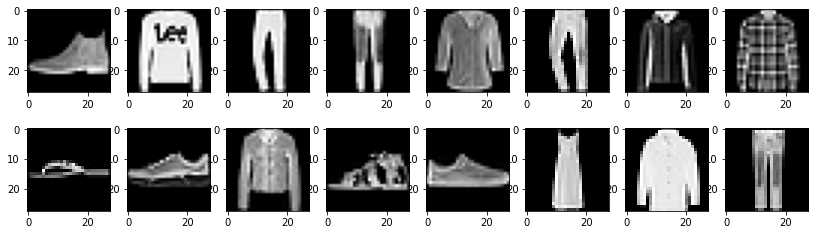

In [4]:
plt.figure(figsize=(14, 4))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(x[i][0], 'gray')

## ネットワーク構築

Convolution2d を使って畳み込み層を作ります。<br>
Convolution2d は指定した層を im2col と col2im で挟み込んで Lowering による畳み込みをサポートします。<br>
DenseAffine を Lowering すると一般にCNNで知られる畳み込み層になりますが、LUT-Network では
ここに DifferentiableLut を組み合わせて作った層を設定することでDenseAffineとは異なる効率の良い畳み込み層を実現します。

In [5]:
# バイナリ時は BIT型を使えばメモリ削減可能
bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32

# define network
net = bb.Sequential([
            bb.RealToBinary(depth_modulation_size=15, frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype),
            bb.Sequential([
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([36*6*6], connection='random', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([36*6], connection='serial', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([36], connection='serial', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(3, 3),
                    fw_dtype=bin_dtype),
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([2*36*6], connection='random', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([2*36], connection='serial', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(3, 3),
                    fw_dtype=bin_dtype),
                bb.MaxPooling(filter_size=(2, 2), fw_dtype=bin_dtype),
            ]),
            bb.Sequential([
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([2*36*6], connection='random', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([2*36], connection='serial', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(3, 3),
                    fw_dtype=bin_dtype),
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([4*36*6], connection='random', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([4*36], connection='serial', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(3, 3),
                    fw_dtype=bin_dtype),
                bb.MaxPooling(filter_size=(2, 2), fw_dtype=bin_dtype),
            ]),
            bb.Sequential([
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([6*256], connection='random', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([256], connection='serial', bin_dtype=bin_dtype),
                        
                        bb.DifferentiableLut([6*6*6*10], connection='random', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([6*6*10], connection='serial', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([6*10], connection='serial', bin_dtype=bin_dtype),
                        bb.AverageLut([10], connection='serial', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(4, 4),
                    fw_dtype=bin_dtype),
            ]),
            bb.BinaryToReal(frame_integration_size=frame_modulation_size, bin_dtype=bin_dtype)
        ])

net.set_input_shape([1, 28, 28])

if bin_mode:
    net.send_command("binary true")

#   print(net.get_info())

## 学習実施

学習を行います

In [6]:
# 前の学習結果があれば読み込む
#bb.load_networks(data_path, net)

# learning
loss      = bb.LossSoftmaxCrossEntropy()
metrics   = bb.MetricsCategoricalAccuracy()
optimizer = bb.OptimizerAdam(learning_rate=0.0001)

optimizer.set_variables(net.get_parameters(), net.get_gradients())

for epoch in range(epochs):
    loss.clear()
    metrics.clear()

    # learning
    with tqdm(loader_train) as t:
        for images, labels in t:
            x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
            t_buf = bb.FrameBuffer.from_numpy(np.identity(10)[np.array(labels)].astype(np.float32))

            y_buf = net.forward(x_buf, train=True)

            dy_buf = loss.calculate(y_buf, t_buf)
            metrics.calculate(y_buf, t_buf)
            net.backward(dy_buf)

            optimizer.update()

            t.set_postfix(loss=loss.get(), acc=metrics.get())

    # test
    loss.clear()
    metrics.clear()
    for images, labels in loader_test:
        x_buf = bb.FrameBuffer.from_numpy(np.array(images).astype(np.float32))
        t_buf = bb.FrameBuffer.from_numpy(np.identity(10)[np.array(labels)].astype(np.float32))

        y_buf = net.forward(x_buf, train=False)

        loss.calculate(y_buf, t_buf)
        metrics.calculate(y_buf, t_buf)

    bb.save_networks(data_path, net)

    print('epoch[%d] : loss=%f accuracy=%f' % (epoch, loss.get(), metrics.get()))

100%|██████████| 938/938 [27:48<00:00,  1.78s/it, acc=0.619, loss=1.72]


epoch[0] : loss=1.666317 accuracy=0.724500


100%|██████████| 938/938 [27:06<00:00,  1.73s/it, acc=0.753, loss=1.62]


epoch[1] : loss=1.630006 accuracy=0.755200


100%|██████████| 938/938 [27:48<00:00,  1.78s/it, acc=0.774, loss=1.61]


epoch[2] : loss=1.603117 accuracy=0.777400


100%|██████████| 938/938 [30:32<00:00,  1.95s/it, acc=0.785, loss=1.6]


epoch[3] : loss=1.604740 accuracy=0.792600


100%|██████████| 938/938 [28:51<00:00,  1.85s/it, acc=0.792, loss=1.6]


epoch[4] : loss=1.608984 accuracy=0.785000


100%|██████████| 938/938 [29:21<00:00,  1.88s/it, acc=0.797, loss=1.6]


epoch[5] : loss=1.608399 accuracy=0.807600


100%|██████████| 938/938 [27:31<00:00,  1.76s/it, acc=0.803, loss=1.59]


epoch[6] : loss=1.600590 accuracy=0.798500


100%|██████████| 938/938 [27:56<00:00,  1.79s/it, acc=0.806, loss=1.59]


epoch[7] : loss=1.607870 accuracy=0.796400


100%|██████████| 938/938 [27:45<00:00,  1.78s/it, acc=0.809, loss=1.59]


epoch[8] : loss=1.585930 accuracy=0.830400


100%|██████████| 938/938 [27:51<00:00,  1.78s/it, acc=0.809, loss=1.59]


epoch[9] : loss=1.600366 accuracy=0.832800


100%|██████████| 938/938 [27:41<00:00,  1.77s/it, acc=0.813, loss=1.59]


epoch[10] : loss=1.629295 accuracy=0.770400


100%|██████████| 938/938 [27:43<00:00,  1.77s/it, acc=0.812, loss=1.59]


epoch[11] : loss=1.619146 accuracy=0.789900


100%|██████████| 938/938 [28:23<00:00,  1.82s/it, acc=0.812, loss=1.59]


epoch[12] : loss=1.599375 accuracy=0.801700


100%|██████████| 938/938 [27:37<00:00,  1.77s/it, acc=0.816, loss=1.59]


epoch[13] : loss=1.608939 accuracy=0.799500


100%|██████████| 938/938 [27:48<00:00,  1.78s/it, acc=0.815, loss=1.59]


epoch[14] : loss=1.629521 accuracy=0.789500


100%|██████████| 938/938 [28:10<00:00,  1.80s/it, acc=0.817, loss=1.59]


epoch[15] : loss=1.586677 accuracy=0.819300


 38%|███▊      | 359/938 [10:58<17:41,  1.83s/it, acc=0.815, loss=1.59]


KeyboardInterrupt: 

## RTL(Verilog)変換

FPGA化するために Verilog に変換します。インターフェースはXilinx社のAXI4 Stream Video 仕様(フレームスタートでtuserが立つ)となります。
MaxPooling の単位で画像サイズが縮小されてしまうので、現状、この単位でしか変換できないため3つに分けて出力しています。

In [ ]:
# export verilog
with open(output_velilog_file, 'w') as f:
    f.write('`timescale 1ns / 1ps\n\n')
    bb.dump_verilog_lut_cnv_layers(f, rtl_module_name + 'Cnv0', net[1])
    bb.dump_verilog_lut_cnv_layers(f, rtl_module_name + 'Cnv1', net[2])
    bb.dump_verilog_lut_cnv_layers(f, rtl_module_name + 'Cnv2', net[3])

# Simulation用ファイルに上書きコピー
shutil.copyfile(output_velilog_file, sim_velilog_file)

# Simulationで使う画像の生成
def img_geneator():
    for data in dataset_test:
        yield data[0] # 画像とラベルの画像の方を返す

img = (bb.make_image_tile(720//28+1, 1280//28+1, img_geneator())*255).astype(np.uint8)
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_160x120.ppm'), img[:,:120,:160])
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_640x480.ppm'), img[:,:480,:640])
bb.write_ppm(os.path.join(rtl_sim_path, 'mnist_test_1280x720.ppm'), img[:,:720,:1280])